<a href="https://colab.research.google.com/github/geo-yrao/ML4ES-tutorials/blob/master/NCICS_ML_lecture_06_MASTER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCICS ML Lesson 06: introduction to logistic regression and regularization with binary classification

Welcome to Lesson 6 of the North Carolina Institute for Climate Studies' Machine Learning Course. This session will build upon the methods we learned in Lesson 5 on machine learning work flow and the basics of binary classification with a k-nearest neighbors classifiers.

## Session purpose:

To introduce another of the most fundamental classification methods, logistic regression, and the related concepts of model regularization and data standardization.

## Session contents:

	1.	Quickly review and ingest the data set;
	2.	Data standardization and visualizations of standardized versus unstandardized data sets;
	3.	Train a regularized logistic regression model using grid search and use a heatmap of the resulting accuracies to understand the "model landscape";
	4.	Comparing the optimal logistic regression model to the optimal k-NN model;

## About the data set:

The data set is the same as Lecture 05's set. It is satellite imagery of our home city of Asheville, taken from Landsat 8, an imaging satellite that was launched in 2013.  Check out the following links for more information:

[USGS Landsat Missions: Landsat 8](https://www.usgs.gov/land-resources/nli/landsat/landsat-8?qt-science_support_page_related_con=0#qt-science_support_page_related_con)

[NASA Landsat Science: Landsat 8](https://landsat.gsfc.nasa.gov/landsat-data-continuity-mission/)

# Preprocess the data

We will be reusing the binary data set that we classified in Lesson 5. To prepare it for classification, we'll go through the same preprocessing steps as last time. In this notebook, we'll pull the dataset from Douglas' GitHub account, in order to avoid the permissions issues that can hamper those of us with multiple Google accounts (ie, everyone in the course).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import sklearn.metrics as skmetrics
import sklearn.model_selection as skmodel
import sklearn.preprocessing as skpreproc

from google.colab import drive
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# Define the path and names of our data files.
path_data_dir =\
  "./ML4ES-tutorials/00-Data/"
filename_data = "NC_L8_GroundTruth.csv"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Clone the data from Douglas' repo and then check which files are present.
try:
    ! git clone https://github.com/geo-yrao/ML4ES-tutorials.git
    ! ls $path_data_dir
except:
    ! ls $path_data_dir

Cloning into 'ML4ES-tutorials'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 141 (delta 68), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (141/141), 1.28 MiB | 5.63 MiB/s, done.
Resolving deltas: 100% (68/68), done.
CDL_2017.tif  label_information.txt  NC_L8_GroundTruth.csv  README.md


## Ingest the data 

Let's take a look at the satellite image of Asheville and then ingest the dataset, before subsetting it down to a binary classfication problem of distinguishing between areas in the image with that are forested versus areas in the image that are covered with water. As mentioned in the Lesson 5 notebook, this reduction is for simplicity's sake. We will work on classifying all five classes (ie, multiclass classification) in a subsequent session. Finally, we will wrangle the data into a form that can be used by Scikit-learn's machine learning pipeline.

Class label information:

1.   **Class 0**: forest (includes data from cdl classes: 'forest', 'deciduous forest', 'evergreen forest', 'mixed forest');
2.   **Class 1**: corn (includes data from cdl class 'corn');
3.   **Class 2**: soy (includes data from cdl class 'soybeans');
4.   **Class 3**: developed/urban (includes data from cdl classes 'developed/open space', 'developed/low intensity', 'developed/med intensity', 'developed/high intensity');
5.   **Class 4**: water (includes data from cdl class 'open water').



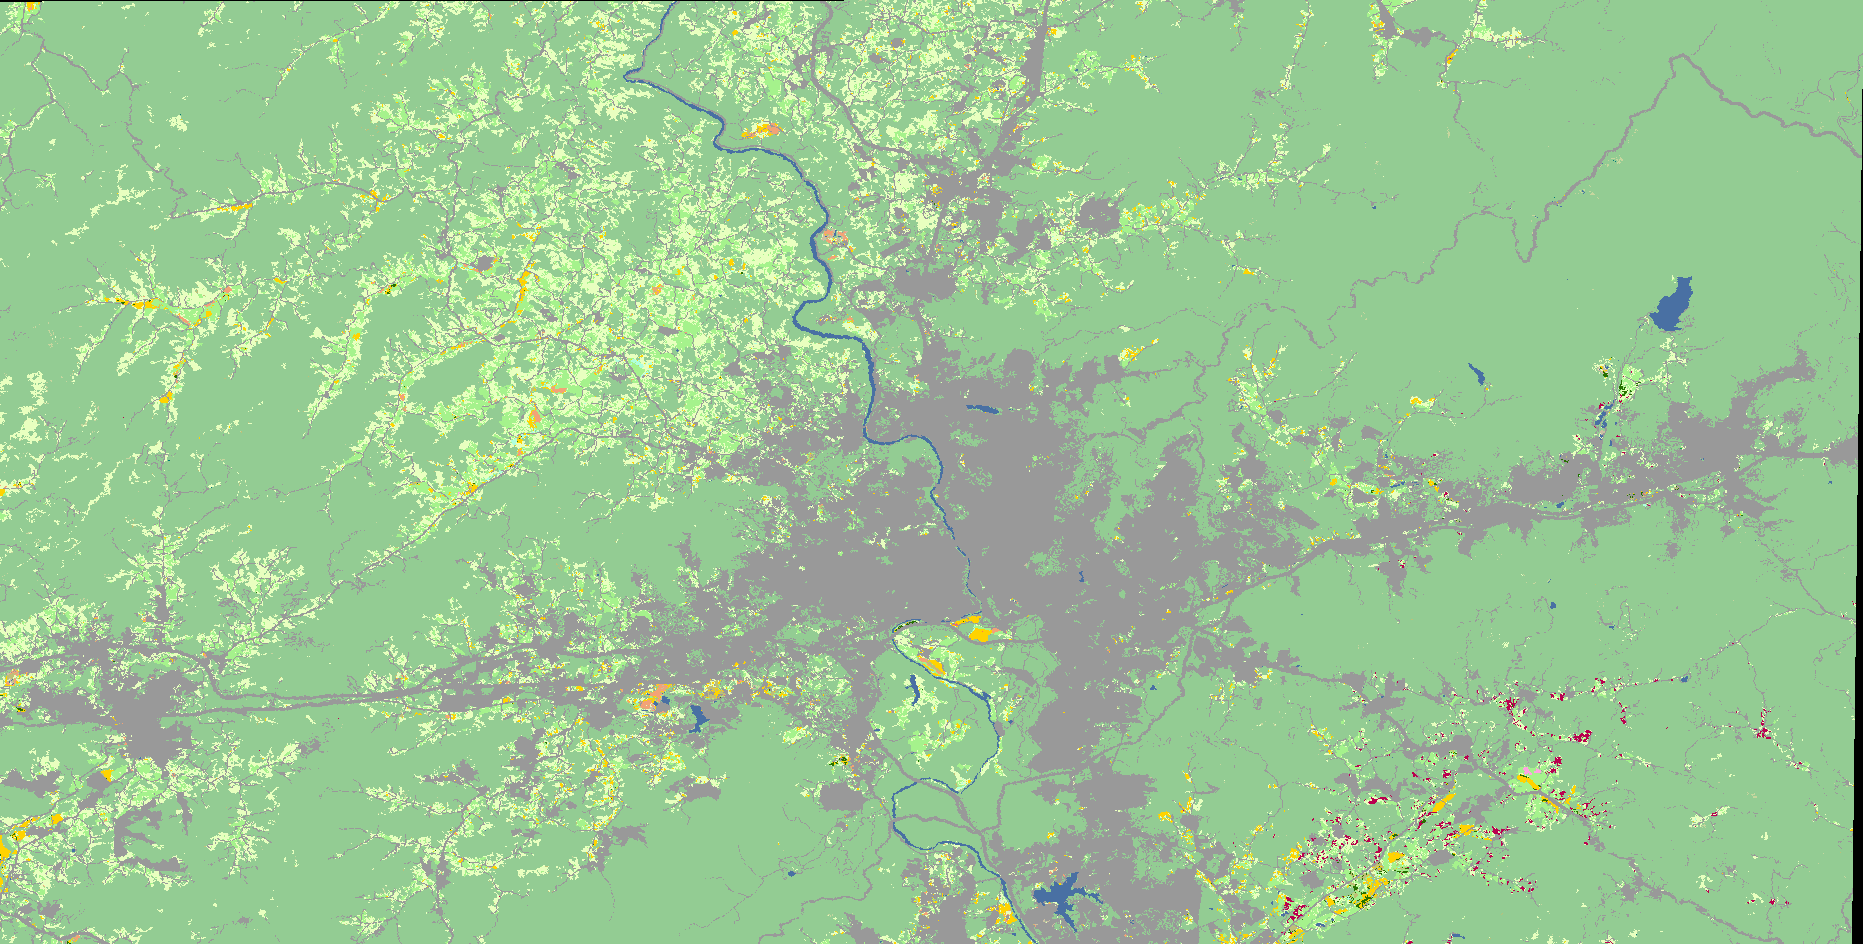

In [ ]:
# Import and display the image.
image = Image.open(path_data_dir+"CDL_2017.tif")
image

In [ ]:
# Import the data, using the first column as the dataframe's index.
df_data = pd.read_csv(path_data_dir+filename_data, index_col=None)

# Delete the column named "Unnamed: 0", which were the row indices in the CSV.
df_data = df_data.drop(labels=["Unnamed: 0"], axis="columns")

# Isolate the data and the target values from the dataframe.
X = df_data.values[:, 3:]  # Data. The six L8 channels in the dataframe.
y = df_data.values[:, 2] # Target. The "class" column in the dataframe.

# Find the array indices for the forest and water samples in the dataset.
indices_samples_forest = np.where(y==0)
indices_samples_water = np.where(y==4)

# Create a binary data set of the data and the target for corn vs. urban pixels.
X_forest_vs_water = np.concatenate((X[indices_samples_forest], X[indices_samples_water]))
y_forest_vs_water = np.concatenate((y[indices_samples_forest], y[indices_samples_water]))

# Binarize the forest and water sample labels.
lb = skpreproc.LabelBinarizer()
y_binary = lb.fit_transform(y_forest_vs_water.tolist())

# Check on the dimensions for sanity.
print("Shape of binary data set:", X_forest_vs_water.shape)

# Take a look at the first five rows of the dataframe.
df_data.head()

Shape of binary data set: (875, 6)


,Latitude,Longitude,Class,B1,B2,B3,B4,B5,B6
0,35.514769,-82.680451,0,127,150,550,226,3609,1441
1,35.753979,-82.520432,0,81,115,426,170,2913,1110
2,35.710635,-82.305661,0,156,220,538,477,2492,2077
3,35.512814,-82.413861,0,245,280,663,507,2732,1531
4,35.520636,-82.853181,0,148,181,534,265,3320,1457


## Visualize class distributions 

As mentioned in the previous lesson, it's always a good idea to try and develop an intuitive understanding of your dataset. Sometimes that's not possible, especially with large, many-dimensional data sets. We'll look at strategies for those kinds of data sets in later lessons.

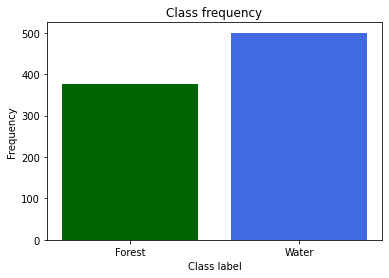

In [ ]:
# Get the counts for each of the unique class labels so we can plot their distribution.
unique, counts = np.unique(y_forest_vs_water, return_counts=True)

# Define a list of the class names to include in the plot.
class_labels_list = ["Forest", "Water"]

# Define a list of attractive colors to use in the notebook's data viz.
class_colors_list = ["darkgreen", "royalblue"]

# Use Matplotlib's Pyplot module to quickly inspect the class distributions.
_ = plt.bar(class_labels_list, counts, color=class_colors_list)

# Use Pyplot to add a title and labels to the x- and y-axises.
plt.title("Class frequency")
plt.xlabel("Class label")
plt.ylabel("Frequency")

# Now that we're done modifying the plot, tell Pyplot to display it.
plt.show()

## Examining binary feature space using a scatterplot of the reflectance

As a refresher, we'll examine a few scatterplots of the binary data set. Band 2 includes light of the wavelengths 0.45 - 0.51 µm (<a href="https://www.wolframalpha.com/input/?i=0.45+%C2%B5m+color">violet</a>-to-<a href="https://www.wolframalpha.com/input/?i=0.51+%C2%B5m+color">light green</a>). Band 3 includes light of the wavelengths 0.53 - 0.59 µm (<a href="https://www.wolframalpha.com/input/?i=0.53+%C2%B5m+color">green</a>-to-<a href="https://www.wolframalpha.com/input/?i=0.59%C2%B5m+color">orange</a>). Band 4 includes light of the wavelengths 0.64 - 0.67 µm (red-to-deep-red). 

Recall that <a href="https://www.wolframalpha.com/"> Wolfram Alpha </a> is a quick and easy way to visualize spectra.

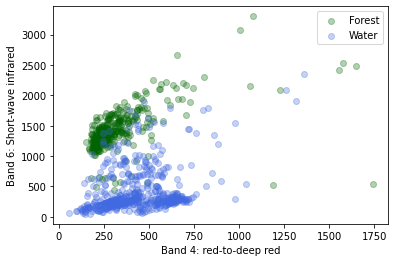

In [ ]:
# Define a Python dictionary object to map the bands' column indices to their
# approximate color spectra names.
band_to_color_map = {
    0: "deep violet-to-violet",
    1: "violet-to-light green",
    2: "green-to-orange",
    3: "red-to-deep red",
    4: "Near-infrared",
    5: "Short-wave infrared",
}

class_data_indices_list = [(0, 375), (375, 875)]

# Define which Landsat-8 bands to include in the scatter plot.
first_band = 3
second_band = 5

# Add some of the plotting aesthetic parameters.
alpha = 0.3

# Initialize a new matplotlib figure and its axes object.
fig, ax = plt.subplots()

# Plot the forest and water samples' spectra to the scatter plot.
for i in range(2):
    idx_tup = class_data_indices_list[i]
    ax.scatter(
        X_forest_vs_water[idx_tup[0]:idx_tup[1], first_band],
        X_forest_vs_water[idx_tup[0]:idx_tup[1], second_band],
        color=class_colors_list[i],
        alpha=alpha,
        label=class_labels_list[i],
    )

# Add a legend to the plot.
ax.legend()

# Add labels to the x- and y-axes. The code is formatted so the labels will change
# if you modify which bands you're plotting.
ax.set_xlabel(f"Band {first_band+1}: "+band_to_color_map[first_band])
ax.set_ylabel(f"Band {second_band+1}: "+band_to_color_map[second_band])

# Show the plot. Google Colab and Jupyter Lab will do this anyways, but it's 
# good practice. And it avoids printed output from the penultimate line of code.
fig.show()

## Preprocessing: standardize the data

In [ ]:
# Use sklearn's built-in standardizer to convert the data into z-scores.
scaler = skpreproc.StandardScaler()
X_scaled = scaler.fit_transform(X_forest_vs_water)

print("Mean by feature:\n", X_scaled.mean(axis=0),"\n")
print("Standard deviation by feature:\n", X_scaled.std(axis=0))

Mean by feature:
 [-7.24436384e-16 -1.66406571e-16  1.80966353e-16  1.57778552e-16
 -1.87786294e-17 -3.56667077e-16] 

Standard deviation by feature:
 [1. 1. 1. 1. 1. 1.]


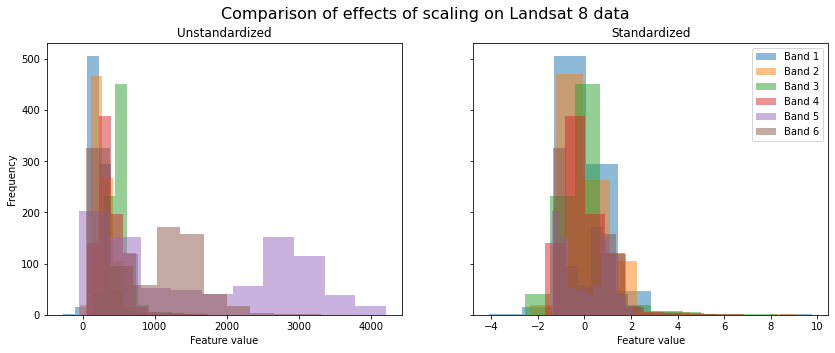

In [ ]:
# Here, we will plot the distributions of the unstandardized and the 
# standardized data sets side-by-side.
alpha = 0.5
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
for i in range(6):
    ax[0].hist(X_forest_vs_water[:, i], alpha=alpha);
    ax[1].hist(X_scaled[:, i], alpha=alpha, label=f"Band {i+1}");
ax[0].set_title("Unstandardized")
ax[1].set_title("Standardized")
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("Feature value")
ax[1].set_xlabel("Feature value")
ax[1].legend()
fig.suptitle("Comparison of effects of scaling on Landsat 8 data", fontsize=16);

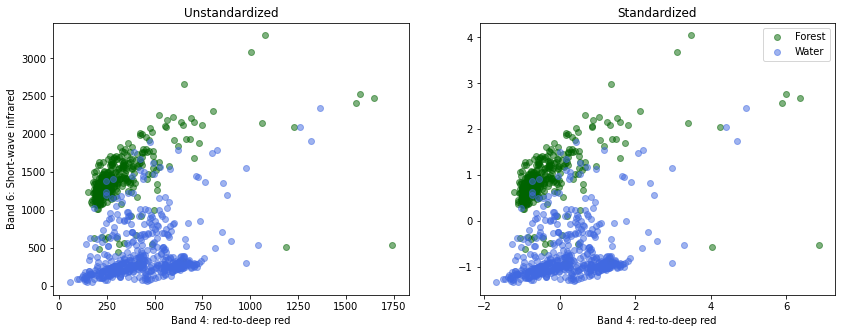

In [ ]:
# Now, we will examine the scatter plots of the two different classes along just
# two different bands of the 
# Initialize a new matplotlib figure and its axes object.
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot the forest and water samples' spectra to the scatter plot.
for i in range(2):
    idx_tup = class_data_indices_list[i]
    ax[0].scatter(
        X_forest_vs_water[idx_tup[0]:idx_tup[1], first_band],
        X_forest_vs_water[idx_tup[0]:idx_tup[1], second_band],
        color=class_colors_list[i],
        alpha=alpha,
        label=class_labels_list[i],
    )
    ax[1].scatter(
        X_scaled[idx_tup[0]:idx_tup[1], first_band],
        X_scaled[idx_tup[0]:idx_tup[1], second_band],
        color=class_colors_list[i],
        alpha=alpha,
        label=class_labels_list[i],
    )


# Add a legend to the plot.
ax[1].legend()

# Add labels to the x- and y-axes. The code is formatted so the labels will change
# if you modify which bands you're plotting.
ax[0].set_xlabel(f"Band {first_band+1}: "+band_to_color_map[first_band])
ax[1].set_xlabel(f"Band {first_band+1}: "+band_to_color_map[first_band])
ax[0].set_ylabel(f"Band {second_band+1}: "+band_to_color_map[second_band])

ax[0].set_title("Unstandardized")
ax[1].set_title("Standardized")

# Show the plot. Google Colab and Jupyter Lab will do this anyways, but it's 
# good practice. And it avoids printed output from the penultimate line of code.
fig.show()

You can see from the side-by-side plots that there really is no difference in the fundamental decision boundaries between the unstandardized and standardized data sets. The only difference are the magnitudes of the bands' values.

# Classification: logistic regression and regularization


Now, onto our first round of classification with logistic regression. To learn more about these methods, check out the following links:

[Scikit-Learn's User Guide: Logistic regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

[Wikipedia: Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression)

[Wikipedia: Regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics))

## Run logistic regression classification and print evaluation metrics

Now, it's time to classify. We'll set up a grid search that will take our stratified k-fold cross-validation split generator and then find the highest-scoring set of hyperparameters for our logistic regressor.

In [ ]:
# Initialize a logistic regression (LR) classifier pipeline. We're using a pipeline
# object here b/c we need to standardize the training data to itself, and then 
# standardize the test data to the training data, rather than standardizing the 
# entire data set at once.  This process mimics "real world" classification, where
# you'd standardize new data to your original data sets, and will give us a better idea
# of which parameters are optimal.  The grid search object treats the pipeline object
# just like any other logistic regressor, but does the dirty work of tracking how to 
# standardize the training/test data for us.
pipeline_logistic_regression = Pipeline(
    [
      ("scaler", skpreproc.StandardScaler()),
      ("LogisticRegression", LogisticRegression(solver="saga"))
    ]
)

# Initialize a stratified 10-fold generator for the cross-validation.
stratified_kfold_generator = skmodel.StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

# Define dictionary of parameters over which to search.
param_grid_dict = {
    "LogisticRegression__penalty":["elasticnet"],
    "LogisticRegression__tol":[0.01*i for i in range(1,11,1)],    
    "LogisticRegression__C":[i*0.1 for i in range (1, 11)] ,
    "LogisticRegression__l1_ratio":[0.05*i for i in range(21)]
}

# Initialize the grid search object.
gridsearcher = skmodel.GridSearchCV(
    estimator=pipeline_logistic_regression,
    param_grid=param_grid_dict,
    scoring=skmetrics.make_scorer(skmetrics.accuracy_score),
    n_jobs=-1,
    cv=stratified_kfold_generator,
    verbose=5
)

# Perform the search.
gridsearcher.fit(X_forest_vs_water, y_forest_vs_water)

Fitting 5 folds for each of 2100 candidates, totalling 10500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 4168 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 8200 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 10497 out of 10500 | elapsed:   38.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 10500 out of 10500 | elapsed:   38.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('LogisticRegression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
        

In [ ]:
# Print the parameters for the optimal classifier.
print(gridsearcher.best_params_)

# Make a DataFrame of the accuracies from the gridsearch.
cv_results = pd.DataFrame.from_dict(gridsearcher.cv_results_)

# Isolate down to the accuracies resulting from the optimal tradeoff between L1
# and L2 regularization (the parameter C represents the weight given to the L2 
# regularization magnitude).
cv_best = cv_results[
    # (cv_results.param_dual==gridsearcher.best_params_["dual"]) &
    # (cv_results.param_penalty==gridsearcher.best_params_["penalty"])
    cv_results.param_LogisticRegression__C==gridsearcher.best_params_["LogisticRegression__C"]
]

grid_accuracy_scores = cv_best.pivot(
    index="param_LogisticRegression__l1_ratio", 
    columns="param_LogisticRegression__tol",
    values="mean_test_score",
)

# Take a look at the accuracies as a function of the error 'tol' and the L1-ratio.
grid_accuracy_scores.head(n=25)

{'LogisticRegression__C': 0.1, 'LogisticRegression__l1_ratio': 0.4, 'LogisticRegression__penalty': 'elasticnet', 'LogisticRegression__tol': 0.02}


param_LogisticRegression__tol,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10
param_LogisticRegression__l1_ratio,,,,,,,,,,
0.00,0.941714,0.940571,0.938286,0.934857,0.936000,0.930286,0.931429,0.931429,0.933714,0.931429
0.05,0.941714,0.940571,0.939429,0.933714,0.936000,0.932571,0.932571,0.931429,0.929143,0.931429
0.10,0.941714,0.940571,0.938286,0.938286,0.933714,0.936000,0.933714,0.929143,0.932571,0.933714
0.15,0.941714,0.940571,0.939429,0.936000,0.937143,0.937143,0.933714,0.932571,0.930286,0.932571
0.20,0.941714,0.940571,0.939429,0.938286,0.937143,0.932571,0.932571,0.931429,0.932571,0.931429
0.25,0.941714,0.941714,0.940571,0.938286,0.936000,0.936000,0.934857,0.931429,0.934857,0.934857
0.30,0.941714,0.942857,0.939429,0.939429,0.938286,0.937143,0.934857,0.931429,0.933714,0.933714
0.35,0.941714,0.942857,0.940571,0.940571,0.938286,0.934857,0.937143,0.933714,0.934857,0.932571
0.40,0.941714,0.944000,0.940571,0.939429,0.937143,0.934857,0.938286,0.933714,0.936000,0.933714


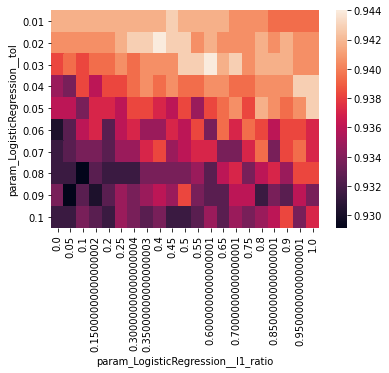

In [ ]:
# Plot the scoring landscape.
ax = seaborn.heatmap(grid_accuracy_scores.transpose())

# Compare the k-nearest neighbors and logistic regression classifiers

In [ ]:
# Binarize the forest and water sample labels.  We do this step because sklearn's
# classifiers will assume that we're dealing with a multiclass classification
# problem if they see any labels that aren't 0 and 1.
lb = skpreproc.LabelBinarizer()
y_binary = lb.fit_transform(y_forest_vs_water.tolist())

# Initialize a logistic regression (LR) classifier object.
lr_best_params = {'C': 0.1, 'l1_ratio': 0.4, 'penalty': 'elasticnet','tol': 0.02}
lr_classifier = LogisticRegression(solver="saga", **lr_best_params)

# Initialize a KNN classifier object. Later, we'll train it and then have it predict the
# classes of withheld testing samples.
knn_classifier = KNeighborsClassifier(n_neighbors=6)

# Initialize a stratified 10-fold generator for the cross-validation.
stratified_kfold_generator = skmodel.StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

# Iterate through each of the splits and train/test the LR classifier. We will 
# store the predictions in the following list, "classfication predictions".
classification_predictions_knn = list()
classification_predictions_lr = list()
for train, test in stratified_kfold_generator.split(X_forest_vs_water, y_forest_vs_water):

    scaler = skpreproc.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_forest_vs_water[train])
    X_test_scaled = scaler.transform(X_forest_vs_water[test])

    # Fit the classifier to the training data. This erases the training from any
    # previous iteration of the loop.
    knn_classifier.fit(X_forest_vs_water[train], y_binary[train].ravel())
    lr_classifier.fit(X_train_scaled, y_binary[train].ravel())

    # Have the newly trained classifier predict the classes of the withheld testing data.
    y_predicted_knn = knn_classifier.predict(X_forest_vs_water[test])
    y_predicted_lr = lr_classifier.predict(X_test_scaled)

    # Add the true class labels and the predicted class labels to the storage list.
    classification_predictions_knn.append((y_binary[test].ravel(), y_predicted_knn.ravel()))
    classification_predictions_lr.append((y_binary[test].ravel(), y_predicted_lr.ravel()))

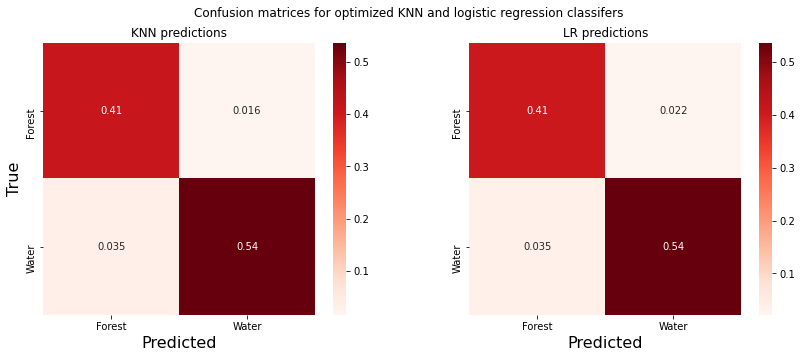

In [ ]:
def calculate_normalized_conf_matrix(classification_predictions):
    cf = np.zeros((2,2))
    for y_true, y_pred in classification_predictions:
        cf += skmetrics.confusion_matrix(y_true, y_pred)
    return cf/cf.sum()

# Show histograms of class distributions across the splits
labels_list = ["Forest", "Water"]
colors_list = ["darkgreen", "royalblue"]

# Loop through the cached predictions and calculate the aggregate confusion matrix,
# both with the raw counts and another that is normalized by the total number of samples.
cf_knn = calculate_normalized_conf_matrix(classification_predictions_knn)
cf_lr = calculate_normalized_conf_matrix(classification_predictions_lr)

# Initialize figure, axes for the two confusion matrices.
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot the raw counts' confusion matrix.
seaborn.heatmap(
    cf_knn, cmap="Reds", annot=cf_knn, square=True, cbar=True,
    xticklabels=labels_list, yticklabels=labels_list,
    ax=ax[0]
)

# Add labels to the x-axis and the y-axis.
ax[0].set_xlabel("Predicted", fontsize=16)
ax[0].set_ylabel("True", fontsize=16)

# Plot the percentages' confusion matrix.
seaborn.heatmap(
    cf_lr, cmap="Reds", annot=True, square=True,
    xticklabels=labels_list, yticklabels=labels_list,
    ax=ax[1]
)

# Add a label to the x-axis.
ax[1].set_xlabel("Predicted", fontsize=16)

# Add a title to the figure.
ax[0].set_title("KNN predictions")
ax[1].set_title("LR predictions")

fig.suptitle("Confusion matrices for optimized KNN and logistic regression classifers")

# Display the figure.
fig.show()

You can see here that these two classifiers are nearly identical in performance. Given how seperable the features are by class, this shouldn't surprise us.